In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train =50
x_train,_=torch.sort(torch.rand(n_train)*5)

In [3]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

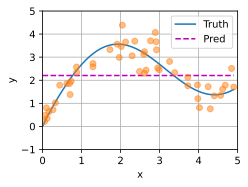

In [5]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

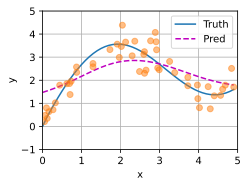

In [8]:
X_repeat=x_test.repeat_interleave(n_train).reshape((-1,n_train))
attention_weights=nn.functional.softmax(-(X_repeat-x_train)**2 /2,dim=1)
y_hat=torch.matmul(attention_weights,y_train)
plot_kernel_reg(y_hat)

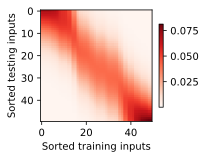

In [9]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [14]:
class NWKernelRegression(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.w=nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self,queries,keys,values):
        queries=queries.repeat_interleave(keys.shape[1]).reshape(-1,keys.shape[1])
        self.attention_weights=nn.functional.softmax(-((queries-keys)*self.w)**2/2,dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)

In [12]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

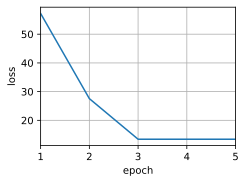

<Figure size 350x250 with 0 Axes>

In [15]:
net=NWKernelRegression()
loss=nn.MSELoss(reduction='none')
trainer=torch.optim.SGD(net.parameters(),lr=0.5)
animator=d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l=loss(net(x_train,keys,values),y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

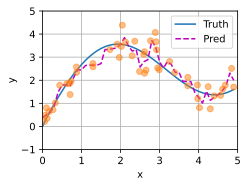

In [16]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

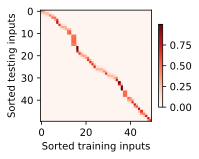

In [17]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')